In [92]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg

import keras
from keras import layers

## 1. Выбрать и подготовить данные для анализа

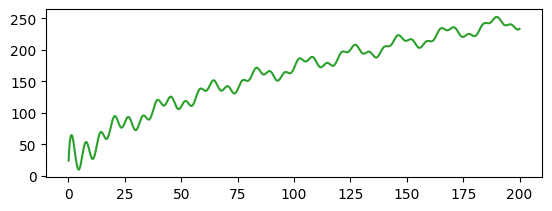

In [93]:
x = np.linspace(0.1, 200, 1000)
y = 50 * np.sin(x) / np.sqrt(x) + np.cos(x * 0.3) * 10 + 2 * np.sqrt(x * 5) * 4 - 7

lim = 800
x_train, y_train = x[:lim], y[:lim]
x_test, y_test = x[lim:], y[lim:]
x_train_reshape = np.reshape(x_train, (-1, 1))
x_test_reshape = np.reshape(x_test, (-1, 1))

plt.figure(1)
plt.subplot(211)
plt.plot(x, y, color='tab:green')

## 3. Построить модель прогнозирования с помощью регрессионных алгоритмов

LinearRegression RMSE: 24.29069288094136
RandomForestRegressor RMSE: 28.141185297770164
forecaster RMSE: 4.342451512983152


<Figure size 640x480 with 0 Axes>

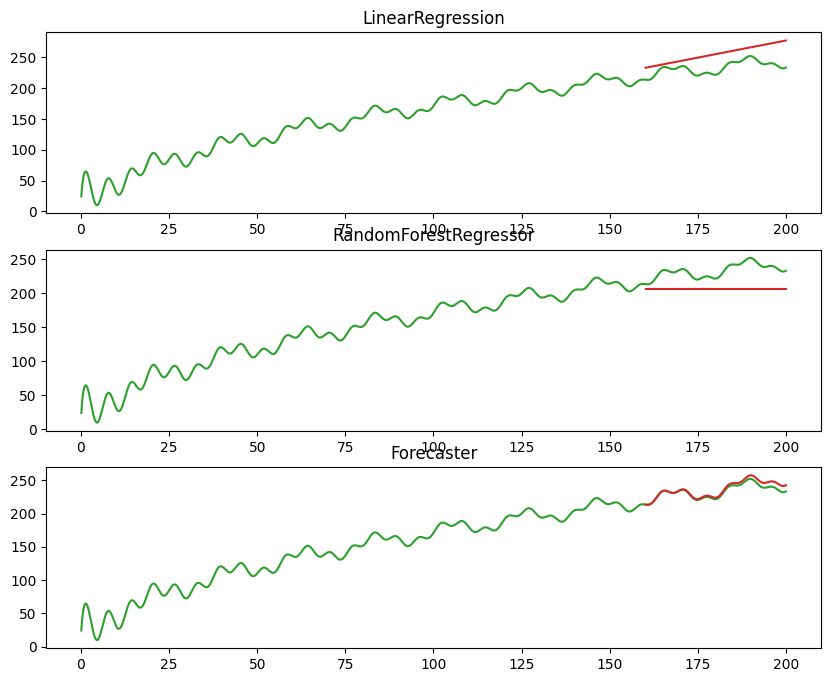

In [94]:
reg1 = LinearRegression()
reg1.fit(x_train_reshape, y_train)
y_predict1 = reg1.predict(x_test_reshape)
rmse = np.sqrt(mean_squared_error(y_test, y_predict1))
print('LinearRegression RMSE:', rmse)

reg2 = RandomForestRegressor(max_depth=3, n_estimators=500)
reg2.fit(x_train_reshape, y_train)
y_predict2 = reg2.predict(x_test_reshape)
rmse = np.sqrt(mean_squared_error(y_test, y_predict2))
print('RandomForestRegressor RMSE:', rmse)

forecaster = ForecasterAutoreg(regressor = LinearRegression(), lags=20)
forecaster.fit(pd.Series(y_train))
predictions = forecaster.predict(steps=x_test.shape[0])
y_predict3 = np.array(predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_predict3))
print('forecaster RMSE:', rmse)

plt.figure(1)
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('LinearRegression')
plt.plot(x, y, color='tab:green')
plt.plot(x_test, y_predict1, color='tab:red')
plt.subplot(312)
plt.title('RandomForestRegressor')
plt.plot(x, y, color='tab:green')
plt.plot(x_test, y_predict2, color='tab:red')
plt.subplot(313)
plt.title('Forecaster')
plt.plot(x, y, color='tab:green')
plt.plot(x_test, y_predict3, color='tab:red')

## 4. Построить модель в форме MLP

Epoch 1/50
54/54 [==============================] - 1s 2ms/step - loss: 3819.1274
Epoch 2/50
54/54 [==============================] - 0s 2ms/step - loss: 264.9916
Epoch 3/50
54/54 [==============================] - 0s 2ms/step - loss: 154.4898
Epoch 4/50
54/54 [==============================] - 0s 2ms/step - loss: 134.6722
Epoch 5/50
54/54 [==============================] - 0s 1ms/step - loss: 124.2227
Epoch 6/50
54/54 [==============================] - 0s 2ms/step - loss: 119.1683
Epoch 7/50
54/54 [==============================] - 0s 2ms/step - loss: 112.6535
Epoch 8/50
54/54 [==============================] - 0s 2ms/step - loss: 110.2808
Epoch 9/50
54/54 [==============================] - 0s 2ms/step - loss: 109.4447
Epoch 10/50
54/54 [==============================] - 0s 1ms/step - loss: 119.3983
Epoch 11/50
54/54 [==============================] - 0s 2ms/step - loss: 100.7535
Epoch 12/50
54/54 [==============================] - 0s 2ms/step - loss: 107.2242
Epoch 13/50
54/54 [=====

<Figure size 640x480 with 0 Axes>

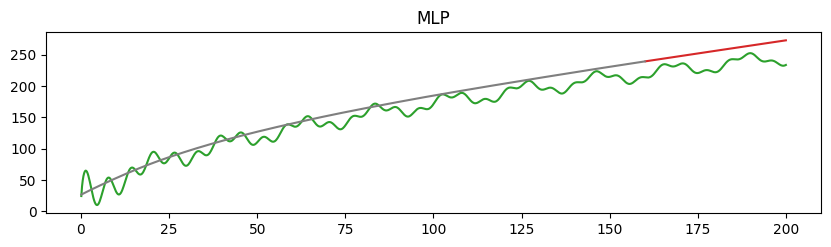

In [95]:
m = keras.Sequential()
m.add(layers.Dense(200, input_shape=(x_train_reshape.shape[1],), activation='elu'))
m.add(layers.Dense(100, activation='elu'))
m.add(layers.Dense(50, activation='elu'))
m.add(layers.Dense(1))
m.compile(loss='mean_squared_error', optimizer='nadam')
m.fit(x_train_reshape, y_train, batch_size=15, epochs=50)
y_predict = m.predict(x_test_reshape)
y_predict_train = m.predict(x_train_reshape)

rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print('MLP RMSE:', rmse)

plt.figure(1)
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title('MLP')
plt.plot(x, y, color='tab:green')
plt.plot(x_test, y_predict, color='tab:red')
plt.plot(x_train, y_predict_train, color='tab:gray')

## 5. Построить рекуррентную модель с помощью блоков GRU или LSTM

In [96]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = pd.DataFrame(y)
dataset = scaler.fit_transform(dataset)
train, test = dataset[0:lim,:], dataset[lim:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [98]:

lstm_blocks = 2

model = keras.Sequential()
model.add(layers.LSTM(lstm_blocks, input_shape=(1, look_back)))
# model.add(layers.Dense(200, input_shape=(1, look_back), activation='elu'))
# model.add(layers.Dense(100, activation='elu'))
# model.add(layers.Dense(50, activation='elu'))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=40, batch_size=10)

Epoch 1/40
80/80 [==============================] - 2s 2ms/step - loss: 0.1599
Epoch 2/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 3/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 4/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 5/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 6/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 7/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 8/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 9/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 10/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 11/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/40
80/80 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 13/40
80/80 [==============================

In [99]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

7/7 [==============================] - 0s 0s/step
Train RMSE: 3.59
Test RMSE: 8.71


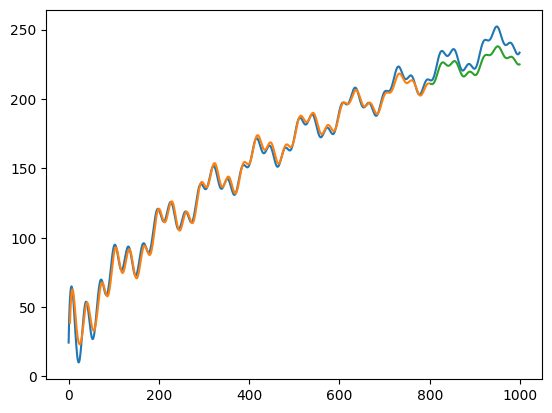

In [100]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()